In [95]:
import pandas as pd

In [96]:
df = pd.read_csv("~/Downloads/kc_house_data.csv")
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [97]:
prices = df["price"]

In [98]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats

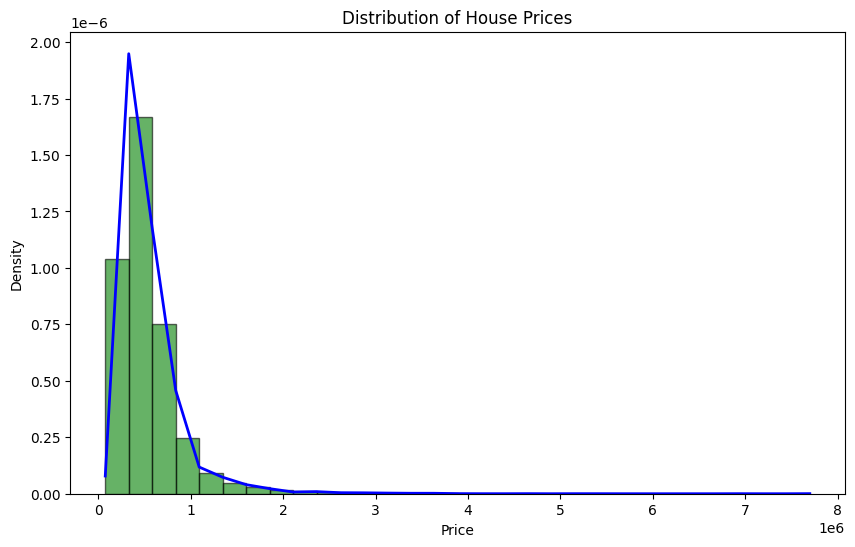

In [99]:
plt.figure(figsize=(10, 6))

count, bins, ignored = plt.hist(prices, bins=30, density=True, alpha=0.6, color='g', edgecolor='black')

kde = stats.gaussian_kde(prices)
plt.plot(bins, kde(bins), color='blue', linewidth=2)

plt.title('Distribution of House Prices')
plt.xlabel('Price')
plt.ylabel('Density')
plt.show()



### По графику можно предположить, что это лог-нормальное распределение

### Попробуем использовать тест Колмогорова-Смирнова

In [100]:
prices = df["price"]
prices.head()

0    221900.0
1    538000.0
2    180000.0
3    604000.0
4    510000.0
Name: price, dtype: float64

In [101]:
import numpy as np

In [102]:
# Оценим параметры лог-нормального распределения

log_prices = np.log(prices)
mean_log = np.mean(log_prices)
std_log = np.std(log_prices, ddof=1)

In [115]:
def lognorm_cdf(x, mean, std):
    # Используем нормальное распределение для логарифмов
    return stats.norm.cdf((np.log(x) - mean) / std)

# Изменённый тест Колмогорова-Смирнова
def ks_test(data: pd.Series, cdf, args=()):
    sorted_data = np.sort(data)

    ecdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    theoretical_cdf = cdf(sorted_data, *args)

    max_diff = np.max(np.abs(ecdf - theoretical_cdf))

    n = len(data)
    p_value = np.exp(-2 * (max_diff ** 2) * n)
    return max_diff, p_value

In [116]:
stat, p_value = ks_test(prices, lognorm_cdf, args=(mean_log, std_log))
print(f"p_value = {p_value:.4}")

if p_value < 0.05:
    print("Отвергаем нулевую гипотезу: распределение данных не соответствует лог-нормальному распределению.")
else:
    print("Нет оснований отвергать нулевую гипотезу: распределение данных может соответствовать лог-нормальному распределению.")

p_value = 2.098e-13
Отвергаем нулевую гипотезу: распределение данных не соответствует лог-нормальному распределению.


### Попробуем проверить, может быть это гамма-распределение
###### Воспользуемся методом хи-квадрат

In [119]:
empirical_mean = np.mean(prices)
empirical_var = np.var(prices, ddof=1)

k_estimated = (empirical_mean ** 2) / empirical_var
theta_estimated = empirical_var / empirical_mean

num_bins = 5
bins = np.linspace(min(prices), max(prices), num_bins + 1)
observed_freq, _ = np.histogram(prices, bins)

In [122]:
import math


def gamma_pdf(x, k, theta):
    return (x ** (k - 1)) * (np.exp(-x / theta)) / (theta ** k * math.gamma(k))

In [123]:
theoretical_freq = []
for i in range(num_bins):
    low = bins[i]
    high = bins[i + 1]

    p = (gamma_pdf(low, k_estimated, theta_estimated) + gamma_pdf(high, k_estimated, theta_estimated)) / 2
    theoretical_freq.append(p * len(prices) * (high - low))

chi_square_stat = np.sum((observed_freq - theoretical_freq) ** 2 / theoretical_freq)
print(f"Χ-square stat: {chi_square_stat}")


Χ-square stat: 204392.46275443054


In [124]:
d = num_bins - 1 - 2
p_value = 1 - stats.chi2.cdf(chi_square_stat, d)
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("Гипотеза о том, что данные распределены по гамма-распределению, отвергается.")
else:
    print("Нет оснований отвергать гипотезу о том, что данные распределены по гамма-распределению.")

p-value: 0.0
Гипотеза о том, что данные распределены по гамма-распределению, отвергается.


### Тогда попробуем проверить, является ли это распределение экспоненциальным

In [74]:
prices.head()

0    221900.0
1    538000.0
2    180000.0
3    604000.0
4    510000.0
Name: price, dtype: float64

In [75]:
prices = prices[prices > 0]
estimated_lambda = 1 / np.mean(prices)
estimated_lambda

np.float64(1.8515496317493346e-06)

In [76]:
ks_statistic, ks_p_value = stats.kstest(prices, 'expon', args=(0, 1 / estimated_lambda))

print("Тест Колмогорова-Смирнова для экспоненциального распределения:")
print(f"p-value: {ks_p_value}")

if ks_p_value > 0.05:
    print("Нет оснований отвергать нулевую гипотезу. Данные могут соответствовать экспоненциальному распределению.")
else:
    print("Отвергаем нулевую гипотезу. Данные могут не соответствовать экспоненциальному распределению.")

Тест Колмогорова-Смирнова для экспоненциального распределения:
p-value: 0.0
Отвергаем нулевую гипотезу. Данные могут не соответствовать экспоненциальному распределению.


### Посмотрим на распределение в зависимости от "возраста"

In [77]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [78]:
len(df[df["yr_renovated"] > 0])

914

In [79]:
len(df)

21613

### Выкинем те дома, которые попали под реновацию (благо их немного, и нам не придется решать, нужно ли считать старый дом с новой реновацией "новым"

In [80]:
df = df[df["yr_renovated"] == 0]
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.0,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
2,5631500400,20150225T000000,180000.0,2,1.0,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.0,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.0,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
5,7237550310,20140512T000000,1225000.0,4,4.5,5420,101930,1.0,0,0,...,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930


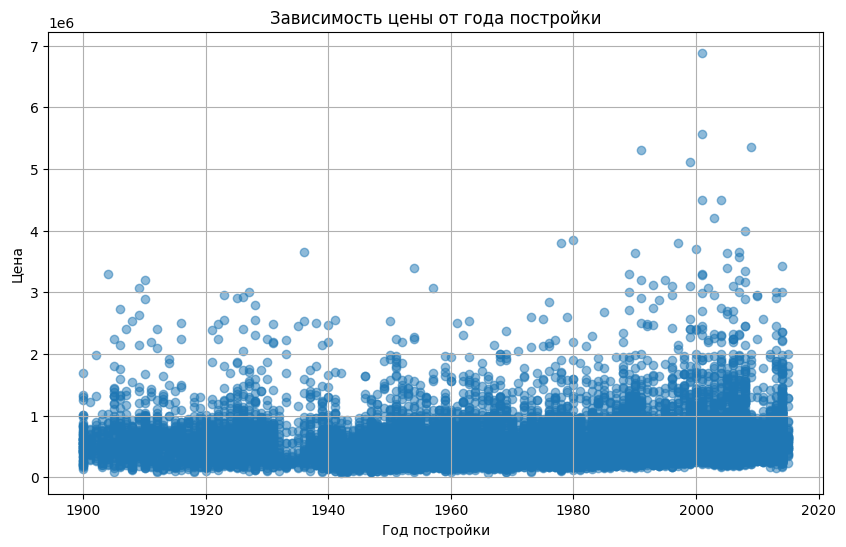

In [81]:
years = df["yr_built"]
prices = df["price"]

plt.figure(figsize=(10, 6))
plt.scatter(years, prices, alpha=0.5)

plt.title('Зависимость цены от года постройки')
plt.xlabel('Год постройки')
plt.ylabel('Цена')

plt.grid(True)
plt.show()

### Теперь посмотрим на распределение цены в зависимости от того, является ли дом новым или старым
###### Лично для себя я бы не стал называть дом "новым", если он был построен раньше начала нулевых годов. Поэтому возьмем отсечку в 2000 год

In [82]:
threshold_year = 2000

df_old = df[df["yr_built"] < threshold_year]
df_new = df[df["yr_built"] >= threshold_year]

print(f"Size of 'old' sample - {len(df_old)},\nSize of 'new' sample - {len(df_new)}")

Size of 'old' sample - 15941,
Size of 'new' sample - 4758


### Можем видеть, что получилось не совсем равномерно (ну тоесть совсем не равномерно), но попробуем поработать с этим

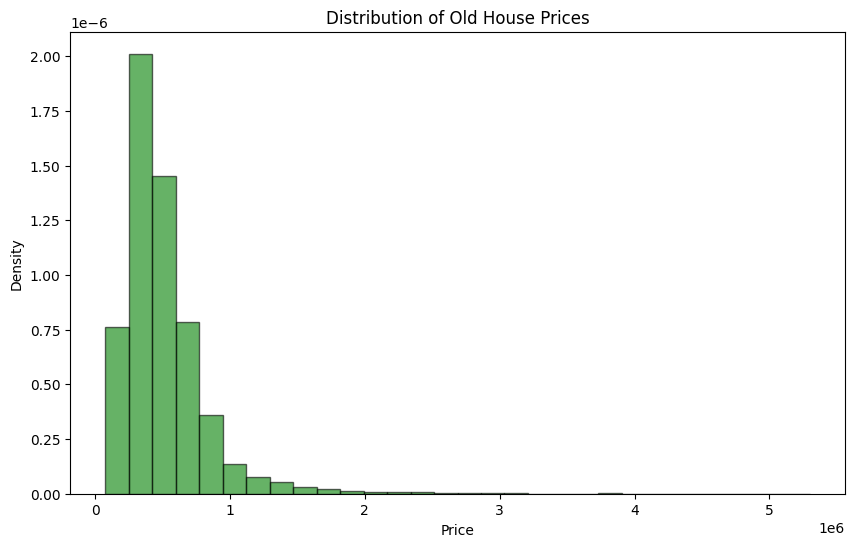

In [83]:
plt.figure(figsize=(10, 6))

count, bins, ignored = plt.hist(df_old["price"], bins=30, density=True, alpha=0.6, color='g', edgecolor='black')

plt.title('Distribution of Old House Prices')
plt.xlabel('Price')
plt.ylabel('Density')
plt.show()

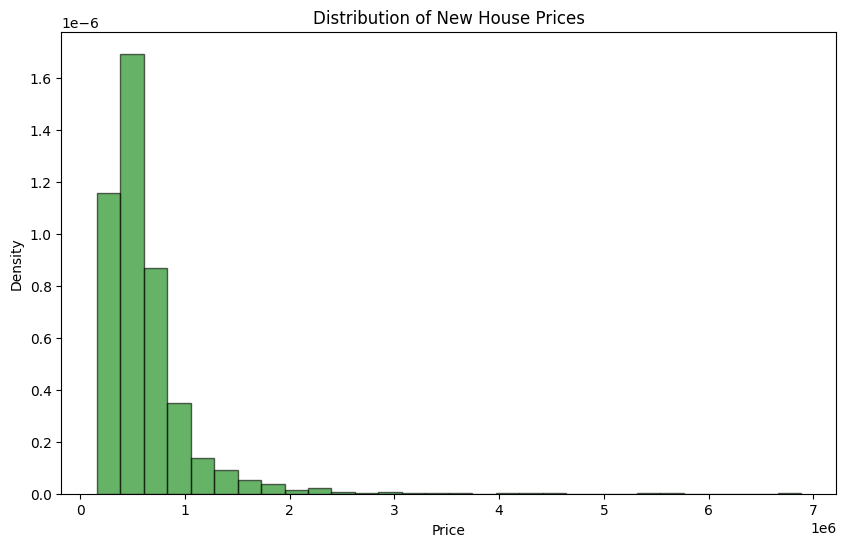

In [84]:
plt.figure(figsize=(10, 6))

count, bins, ignored = plt.hist(df_new["price"], bins=30, density=True, alpha=0.6, color='g', edgecolor='black')

plt.title('Distribution of New House Prices')
plt.xlabel('Price')
plt.ylabel('Density')
plt.show()

### Ну, выглядит похоже

In [85]:
def empirical_cdf(sample: np.array):
    sorted_sample = np.sort(sample)
    n = len(sorted_sample)
    return lambda x: np.searchsorted(sorted_sample, x, side='right') / n


def ks_test(sample1: np.array, sample2: np.array):
    cdf1 = empirical_cdf(sample1)
    cdf2 = empirical_cdf(sample2)

    all_values = np.sort(np.concatenate((sample1, sample2)))
    diffs = np.abs(np.array([cdf1(val) - cdf2(val) for val in all_values]))

    ks_statistic = np.max(diffs)

    n1 = len(sample1)
    n2 = len(sample2)

    en = np.sqrt(n1 * n2 / (n1 + n2))
    p_value = np.exp(-2 * (en * ks_statistic) ** 2)

    return ks_statistic, p_value

In [86]:
old_prices = df_old["price"].values
new_prices = df_new["price"].values

In [87]:
ks_statistic, p_value = ks_test(old_prices, new_prices)

print(f"p-value: {p_value}")
if p_value > 0.05:
    print("Нет оснований отвергать нулевую гипотезу: выборки распределены одинаково.")
else:
    print("Отвергаем нулевую гипотезу: выборки распределены по-разному.")

p-value: 3.201061191047402e-82
Отвергаем нулевую гипотезу: выборки распределены по-разному.


### Воспользуемся библиотечным методом для теста Манна-Уитни, чтобы проверить, распределены ли цены одинаково

In [88]:
alternatives = ['less', 'greater', 'two-sided']

for alt in alternatives:
    stat, p_value = stats.mannwhitneyu(old_prices, new_prices, alternative=alt)
    print(f"p-value: {p_value}")
    if p_value > 0.05:
        print("Нет оснований отвергать нулевую гипотезу: выборки распределены одинаково.")
    else:
        print("Отвергаем нулевую гипотезу: выборки распределены по-разному.")

p-value: 8.11826016068887e-117
Отвергаем нулевую гипотезу: выборки распределены по-разному.
p-value: 1.0
Нет оснований отвергать нулевую гипотезу: выборки распределены одинаково.
p-value: 1.623652032137774e-116
Отвергаем нулевую гипотезу: выборки распределены по-разному.


### Последняя проверка - посмотрим, правда ли, что с увеличением жилплощади растет и цена?

In [89]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.0,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
2,5631500400,20150225T000000,180000.0,2,1.0,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.0,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.0,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
5,7237550310,20140512T000000,1225000.0,4,4.5,5420,101930,1.0,0,0,...,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930


In [90]:
sqft_living = df["sqft_living"].values
prices = df["price"].values

### Воспользуемся методом корреляции Пирсона

In [91]:
def pearson(sample1: np.array, sample2: np.array) -> float:
    mean_first = np.mean(sample1)
    mean_second = np.mean(sample2)

    covariance = np.mean((sample1 - mean_first) * (sample2 - mean_second))
    std_first = np.std(sample1)
    std_second = np.std(sample2)

    pearson_corr = covariance / (std_first * std_second)
    return pearson_corr

In [92]:
pearson_corr = pearson(sqft_living, prices)
print(f"Коэффициент корреляции Пирсона: {pearson_corr}")

Коэффициент корреляции Пирсона: 0.6980902174455823


In [93]:
if p_value < 0.05:
    print("Есть статистически значимая корреляция между жилой площадью и ценой.")
    if pearson_corr > 0:
        print("Корреляция положительная: с увеличением жилплощади цена имеет тенденцию расти.")
    else:
        print("Корреляция отрицательная: с увеличением жилплощади цена имеет тенденцию уменьшаться.")
else:
    print("Нет статистически значимой корреляции между жилой площадью и ценой.")

Есть статистически значимая корреляция между жилой площадью и ценой.
Корреляция положительная: с увеличением жилплощади цена имеет тенденцию расти.


### Хотя бы один тест нормально отработал и выдал результат, который похож на реальность!
###### (Хотя может действительно в первых двух пунктах стоило думать как инопланетянин)

In [94]:
corr_coefficient, p_value = stats.kendalltau(sqft_living, prices)
print(f"Коэффициент корреляции Кендала: {corr_coefficient}")
if p_value < 0.05:
    print("Есть статистически значимая корреляция между жилой площадью и ценой.")
    if pearson_corr > 0:
        print("Корреляция положительная: с увеличением жилплощади цена имеет тенденцию расти.")
    else:
        print("Корреляция отрицательная: с увеличением жилплощади цена имеет тенденцию уменьшаться.")
else:
    print("Нет статистически значимой корреляции между жилой площадью и ценой.")

Коэффициент корреляции Кендала: 0.45967664184758855
Есть статистически значимая корреляция между жилой площадью и ценой.
Корреляция положительная: с увеличением жилплощади цена имеет тенденцию расти.
